The first part of the project involves modeling the exchange between a single photon in the resonator and an excited qubit state. To do this I first start by evolving the system according to the hamiltonian along with associated sources of decoherence. The block below simply imports the libraries needed to execute this:

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy import fft
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit

After that we must initialize the states and operators. For this part of the project we simply start with the qubit in the excited state and the resonator in the vacuum state. I then define the associated annihilation operators for both parts of the system $a$ and $\sigma_-$:

In [2]:
psi0 = tensor(fock(2,1), fock(2,0)) #define basis
a  = tensor(qeye(2), destroy(2)) #destroy resonator state
sm = tensor(destroy(2), qeye(2)) #destroy qubit state

Next, it is important to take account the decoherence of the system to accurately replicate plots 1c and 1d. I start by defining the relevant coherence times given in the paper. These are $T1q = 650$ ns, $T2q = 150$ ns, and $T1r = 3.5$ $\mu$s where q and r refer to the qubit and the resonator respectively. There was no significant dephasing of the resonator. Note also that as shown in class the $T2q$ time also gives the dephasing time of the qubit through the relation: 

$T_\phi = \frac{2}{\frac{1}{T2q}-\frac{1}{2 T1q}}$

Also important is the thermal excitation factor representing the effect of thermal fluctiations in the ambient electromagntic field:

$n_T = \frac{1}{e^{\hbar \omega_r/{k T}}-1}$

In [5]:
#in ns
T1q = 650
T2q = 150
T1r = 3500
Tphiq = 2/((1/T2q)-(1/(2*T1q)))

#thermal factor
nT = 1/(exp(1.05e-34*6.57e9/(1.38e-23*25e-3))-1)

To represent the decoherence of the system we use the standard Lindblad master equation in the rotating frameform given by:

\begin{equation}
\dot \rho = -\frac{i}{\hbar} [H,\rho] + \frac{1}{2}\sum_{i}(2C_i\rho C_i^\dagger - \{ C_i^\dagger C_i, \rho \})
\end{equation}

where $H$ is the Hamiltonian do be defined below, $\rho$ is the qubit-resonator density matrix and and the $C_i$'s are the so-called collapse operators associated with different sources of decoherence. As shown in class these collapse operators can generally be approximated from the the coherence times. For out system the resonator collapse operators take the form:

\begin{equation}
C_\uparrow =  \sqrt{\frac{n_T}{T1r}} (I\otimes a^\dagger),\ C_\downarrow =  \sqrt{\frac{1+n_T}{T1r}} (I\otimes a)
\end{equation}

The collapse operators for the qubit are derived by exchanging the coherence times and operators:

\begin{equation}
C_\uparrow =  \sqrt{\frac{n_T}{T1q}} (\sigma_+\otimes I),\ C_\downarrow =  \sqrt{\frac{1+n_T}{T1q}} (\sigma_-\otimes I)
\end{equation}

The dephasing collapse operator for the qubit is given by:

\begin{equation}
C_\phi =  \sqrt{\frac{1+2 n_T}{T_\phi}} (\sigma_z\otimes I)
\end{equation}

Thus we can define the collapse operators with the following QuTip snippet:

In [7]:
Cadown = sqrt((1+nT)/T1r)*a
Caup = sqrt(nT/T1r)*a.dag()
Cq1down = sqrt((1+nT)/T1q)*sm
Cq1up = sqrt(nT/T1q)*sm.dag()
Cq2 = sqrt((2*nT+1)*(1/Tphiq))*(2*sm.dag()*sm - 1)

Thus the next step in the code is to simulation the evolution of the sytem Hamiltonian with decoherence for range of cavity-qubit detuning frequencies ($\Delta$). We start by defining the timing and necessary arrays to loop over:

In [8]:
times = np.linspace(0.0, 500, 1000) #time array
DRange = np.linspace(40.0e-3,-40.0e-3,100) #detuning array from -40e-3 GHz to 40e-3 GHz
L = DRange.size
resultMatrix1 = np.zeros((100,1000)) #matrix for evolution data
resultMatrix2 = np.zeros((100,1000)) #matrix for fourier transform data

The system hamiltonian as given in the paper is:

\begin{equation}
\frac{H}{\hbar} = \Delta(t)\sigma_+\sigma_-+(\frac{\Omega}{2}\sigma_+a+\frac{\Omega_q(t)}{2}\sigma_++\frac{\Omega_r(t)}{2}a^\dagger)+h.c.
\end{equation}

Since we are not driving the system only relevant couplings are $\Delta$ given as DRange above ans $\Omega$ = 19 MHz as determined experimentally. So we have to define this as well:

In [10]:
omega = 2 * np.pi * 19e-3

Thus the loop finding the evoltion and fourier transform of the data takes the form:

In [15]:
for i in range(L):
    H = 0.5 * omega * sm.dag() * a + 0.5 * omega * sm * a.dag()+2*pi*DRange[i]*sm.dag()*sm #Hamiltonian
    result = mesolve(H, psi0, times, [Cadown,Caup,Cq1down,Cq1up,Cq2], [sm.dag()*sm]) #evolve
    resultMatrix1[i] = result.expect[0] #give the excited state pobabiltiy time seris
    resultMatrix2[i] = abs(fft(result.expect[0])) #take the fourier transform

Now we can plot the excitation probability from the first matrix (rows = time series, columns = detuning series):

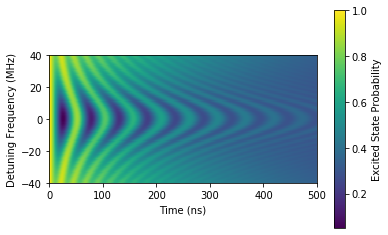

In [16]:
plt.imshow(resultMatrix1,aspect = 3.0, extent=[0,500,-40,40])
plt.xlabel('Time (ns)')
plt.ylabel('Detuning Frequency (MHz)')
plt.colorbar(label = 'Excited State Probability')
plt.show()

To plot the fourier transform we need to first determine the frequecy array which takes the form below. See
"How to interpret FFT results - Complex DFT, frequency bins, and FFTshift." guassianwaves.com. Nov. 15, 2015 
https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/

In [17]:
N = resultMatrix1[0].size #sample size
T = 0.5e-9 #sampling period
f = np.linspace(0.0,(N//2)*(1.0/(N*T)),(N//2)) #positive range frequencies

I had to cut off the first five elements in the frequency array to neglect the significant DC noise and extract the DC noise but was able to generate this plot:

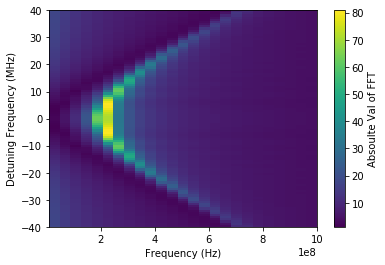

In [20]:
plt.imshow(resultMatrix2[0:100,5:30],aspect = 1e7, extent=[f[5],f[len(f)-1],-40,40])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Detuning Frequency (MHz)')
plt.colorbar(label = 'Absoulte Val of FFT')
plt.show()

In an attempt to fit the peaks to a hyperbolic curve I wrote some code which finds the peaks within the this contour plot, finds and finds a rabi frequency $\Omega$ such that the frequency peaks fit the following form from the paper ($f = \sqrt{\Delta^2 + \Omega^2}/2 \pi$):

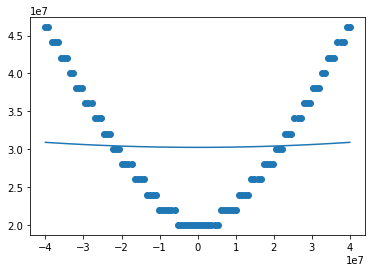

In [22]:
fftData = resultMatrix2[0:100,5:30]
Lf = fftData[:,0].size
freqs = []
for i in range(Lf):
    pksList = find_peaks_cwt(fftData[i,:],range(1,2))
    pk = pksList[len(pksList)-1]
    freq = f[pk+5]
    freqs.append(freq)
    
def quadFit(D,Om):
    return np.sqrt(Om**2+D**2)*(1/(2*pi))


params,cov = curve_fit(quadFit,DRange*10**9,freqs,p0 = [2e7])

yL = []
for j in range(len(DRange)):
    yL.append(quadFit(DRange[j]*10**9,params[0]))
    
y = np.asarray(yL)

fig = plt.scatter(DRange*10**9,freqs)
plt.plot(DRange*1e9,y)
plt.show(fig)

Clearly the form is not flexible enough so I ended up abandoning this.